# Working with BFL FLUX in Pixeltable

This notebook demonstrates how to use Black Forest Labs (BFL) FLUX models for image generation and editing through Pixeltable.

[BFL FLUX](https://docs.bfl.ai/) offers state-of-the-art text-to-image generation with models like FLUX.2 and FLUX 1.1, featuring:
- High-fidelity image generation with accurate hands, faces, and textures
- Multi-reference image editing
- Precise hex color control
- Typography and text rendering

## Prerequisites

1. A BFL API key from [dashboard.bfl.ai](https://dashboard.bfl.ai)
2. Pixeltable installed


## Setup

First, install Pixeltable and set up your API key:


In [ ]:
# If running from the pixeltable repository, install in editable mode:
import sys
sys.path.insert(0, '/Users/pierre/pixeltable')

# Otherwise, uncomment to install from pip:
# %pip install pixeltable

In [ ]:
import os
import getpass

# Set your BFL API key - get one from https://dashboard.bfl.ai
if 'BFL_API_KEY' not in os.environ:
    os.environ['BFL_API_KEY'] = getpass.getpass('Enter your BFL API key: ')

In [ ]:
import pixeltable as pxt
from pixeltable.functions import bfl

# Create a directory for our examples
pxt.drop_dir('bfl_demo', force=True)
pxt.create_dir('bfl_demo')

Created directory 'bfl_demo'.


## Text-to-Image Generation

Generate images from text prompts using FLUX models. FLUX 1.1 [pro] offers fast, reliable results.


In [ ]:
# Create a table for image generation
prompts_t = pxt.create_table(
    'bfl_demo.prompts',
    {'prompt': pxt.String, 'style': pxt.String},
    if_exists='replace'
)

# Add a computed column that generates images from prompts
prompts_t.add_computed_column(
    image=bfl.generate(
        prompts_t.prompt,
        model='flux-pro-1.1',
        width=1024,
        height=1024
    )
)

Created table 'prompts'.
Added 0 column values with 0 errors.


No rows affected.

In [ ]:
# Insert some prompts to generate images
prompts_t.insert([
    {'prompt': 'A majestic mountain landscape at golden hour, photorealistic', 'style': 'landscape'},
    {'prompt': 'A futuristic city with flying cars and neon lights, cyberpunk style', 'style': 'sci-fi'},
])

Inserting rows into `prompts`: 2 rows [00:00, 1160.89 rows/s]
Inserted 2 rows with 0 errors.


2 rows inserted, 6 values computed.

prompt  \
0  A majestic mountain landscape at golden hour, ...   
1  A futuristic city with flying cars and neon li...   

                                               image  
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...
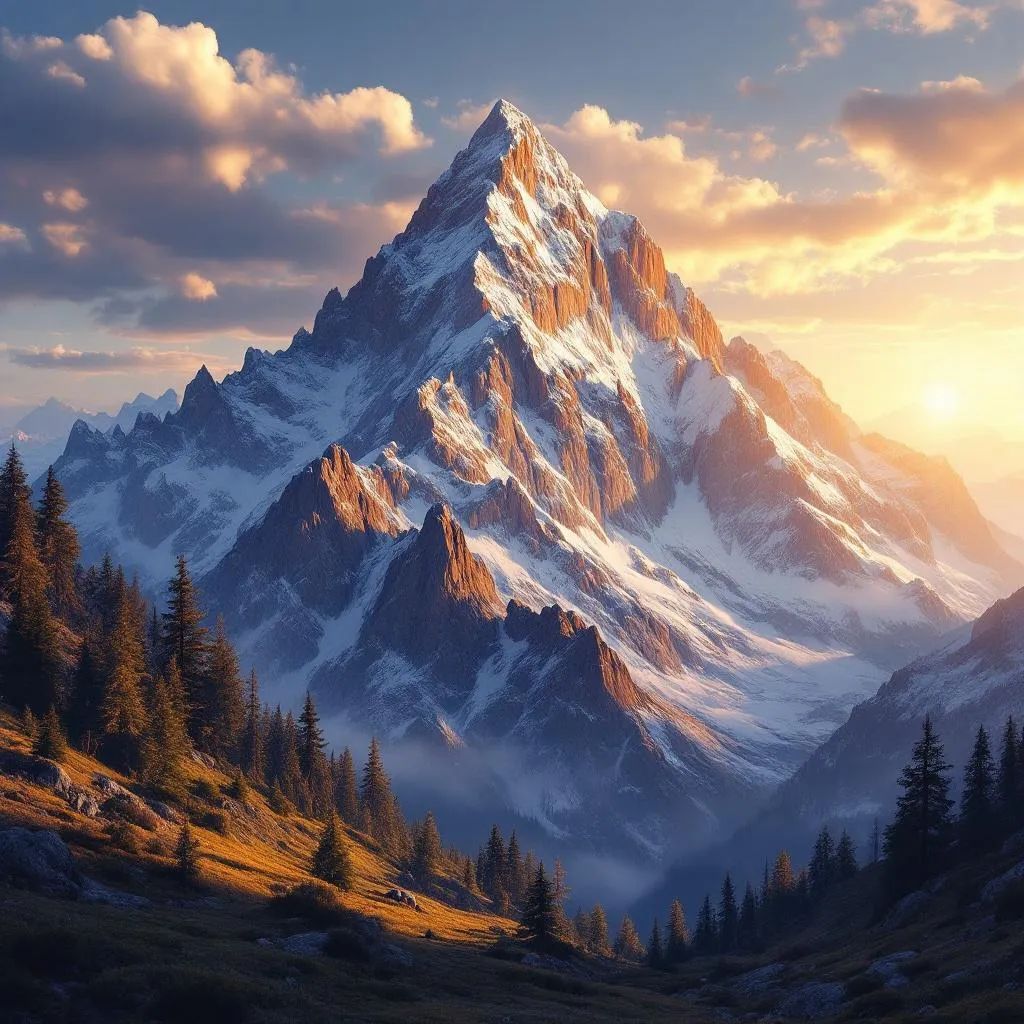
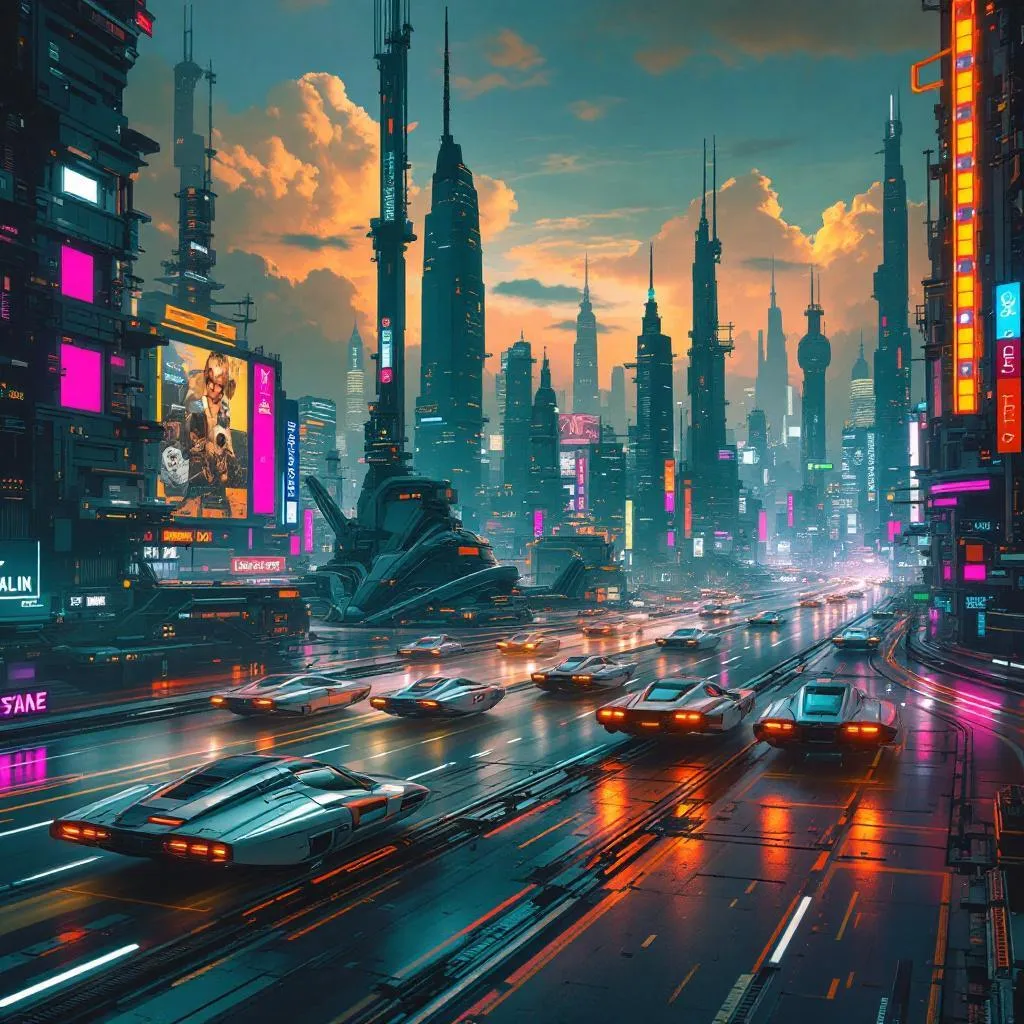

In [ ]:
# View the generated images
prompts_t.select(prompts_t.prompt, prompts_t.image).show()

## Image Editing

Edit existing images with text prompts using FLUX models. This is powerful for:
- Changing backgrounds
- Adding or removing objects
- Style transfer
- Multi-reference editing


In [ ]:
# Create a table for image editing
edit_t = pxt.create_table(
    'bfl_demo.edits',
    {
        'original': pxt.Image,
        'edit_prompt': pxt.String
    },
    if_exists='replace'
)

# Add computed column for edited images
edit_t.add_computed_column(
    edited=bfl.edit(
        edit_t.edit_prompt,
        edit_t.original,
        model='flux-2-pro'
    )
)

Created table 'edits'.
Added 0 column values with 0 errors.


No rows affected.

In [ ]:
# Insert an image and edit prompt
# Replace with your own image URL or path
edit_t.insert(
    original='https://images.unsplash.com/photo-1506744038136-46273834b3fb?w=1024',
    edit_prompt='Add a dramatic sunset with vibrant orange and purple colors'
)

Inserting rows into `edits`: 1 rows [00:00, 560.89 rows/s]
Inserted 1 row with 0 errors.


1 row inserted, 4 values computed.

original  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                              edited  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                         edit_prompt  
0  Add a dramatic sunset with vibrant orange and ...
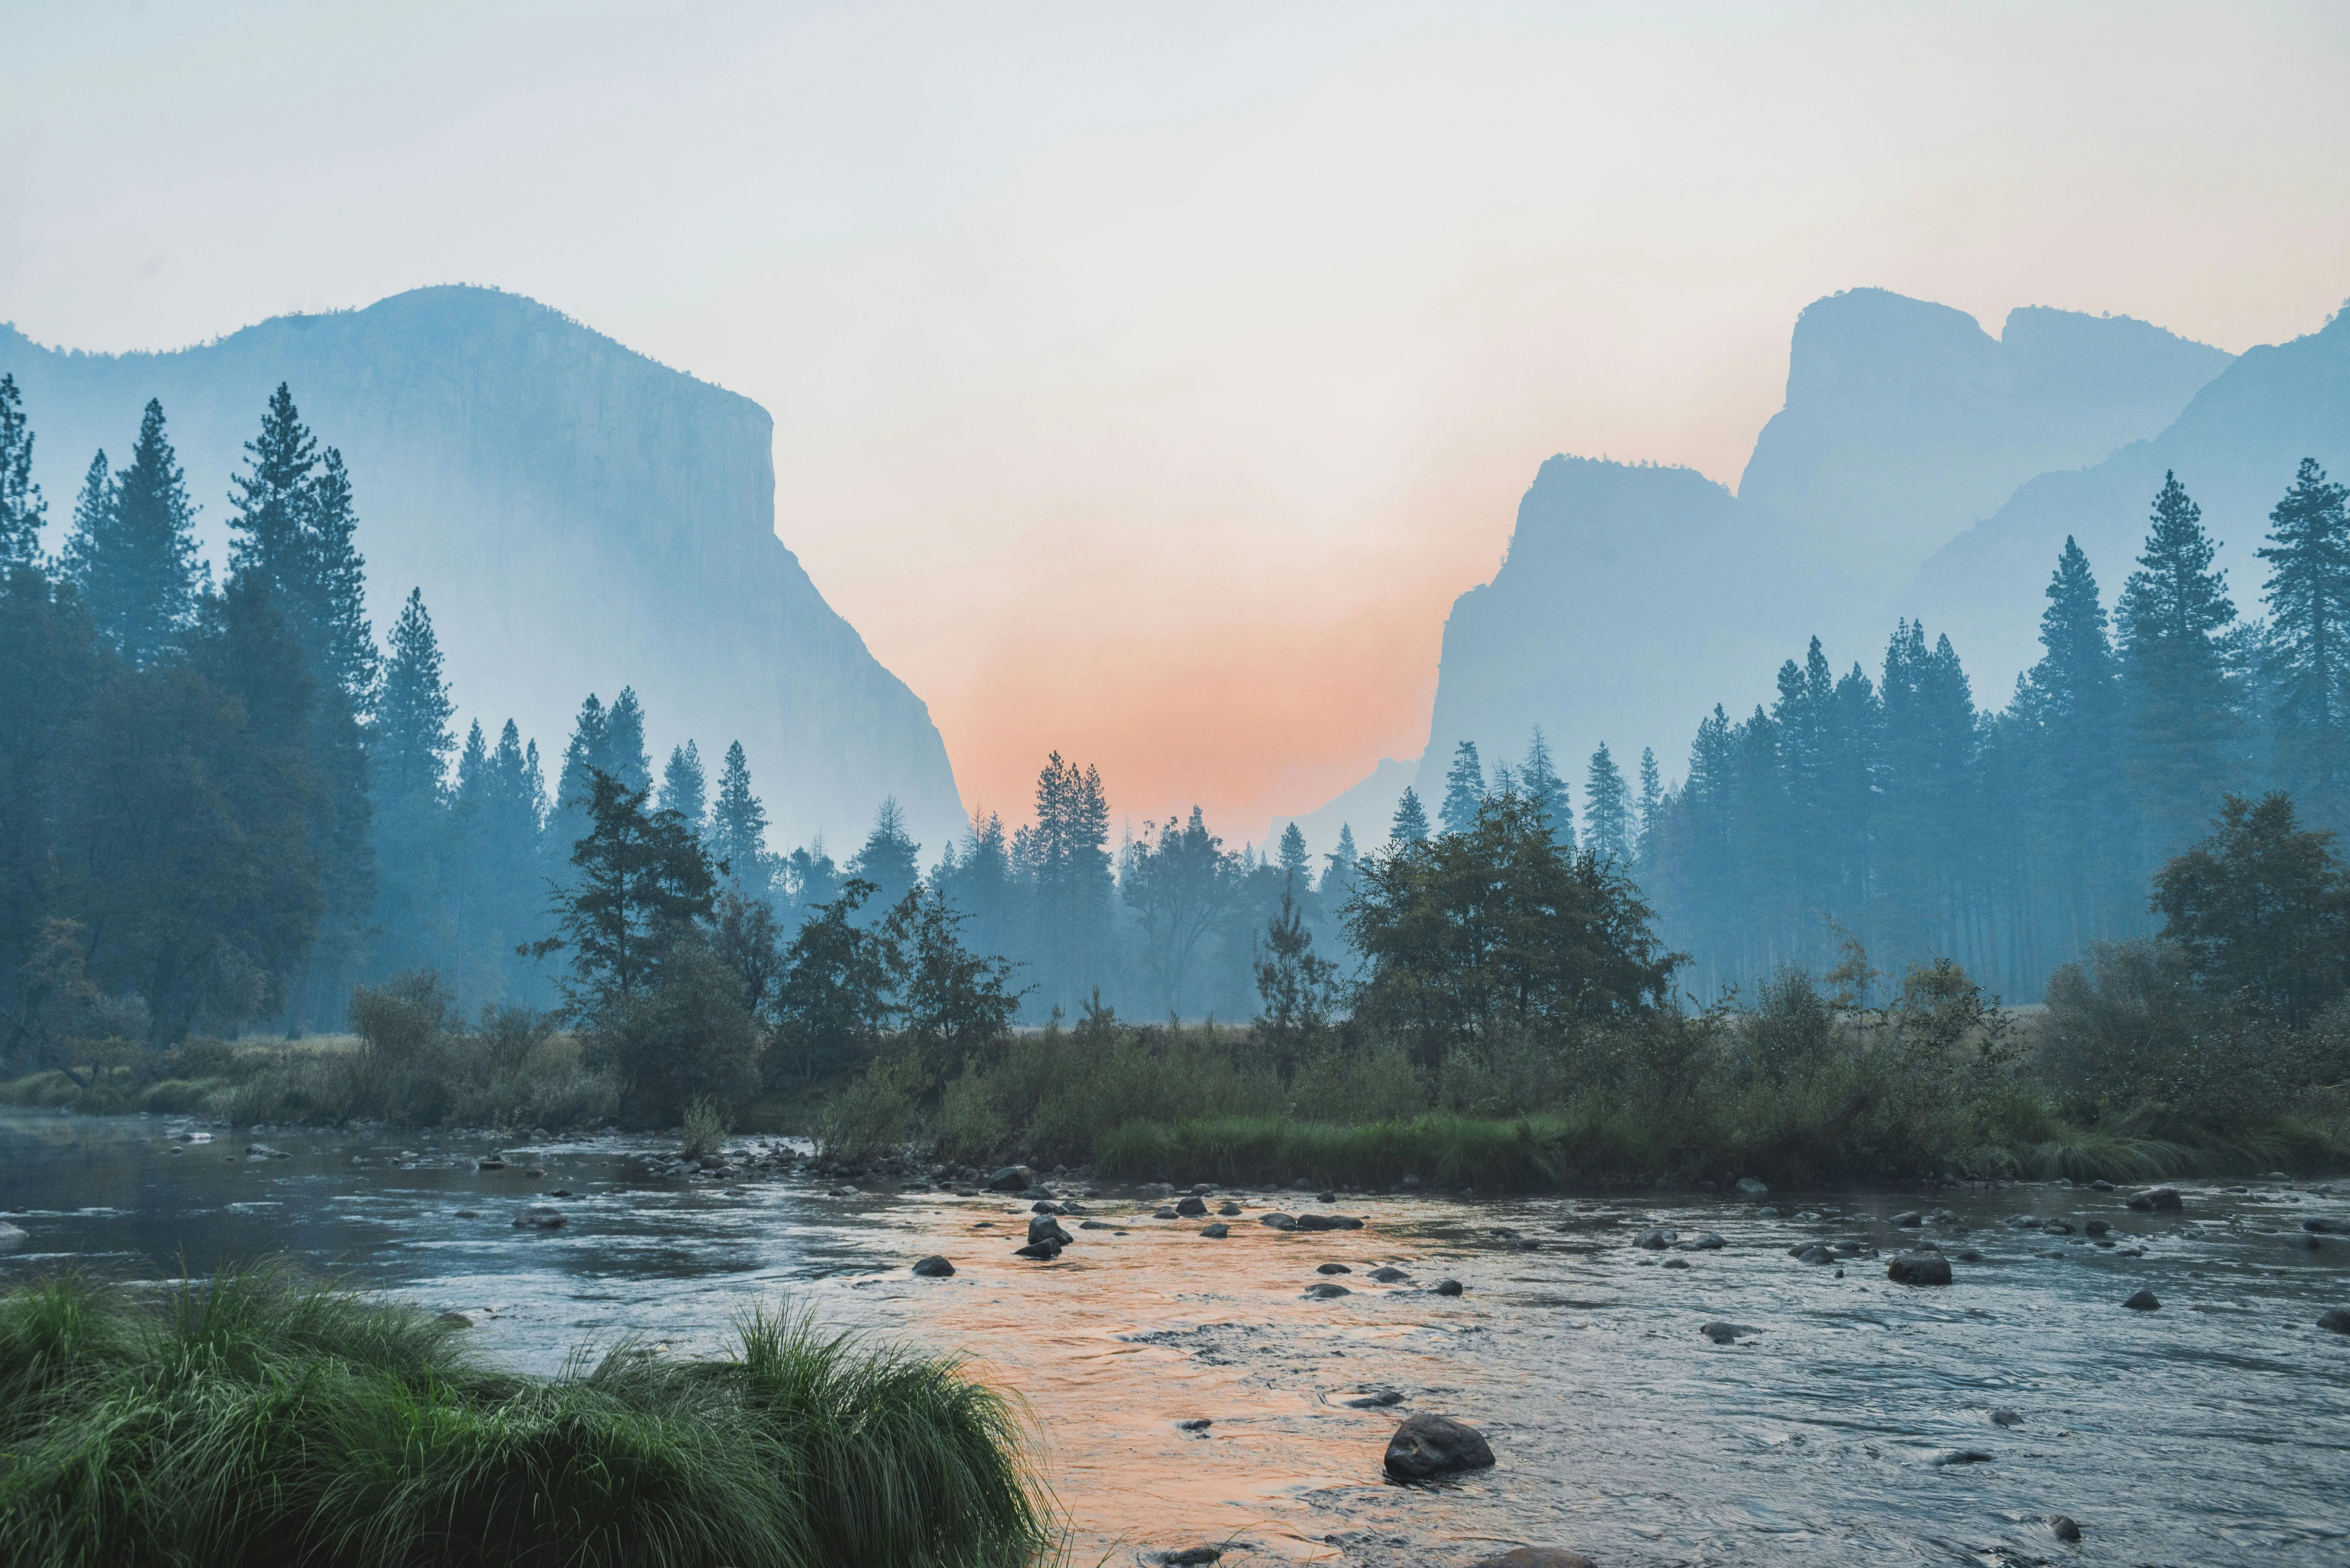
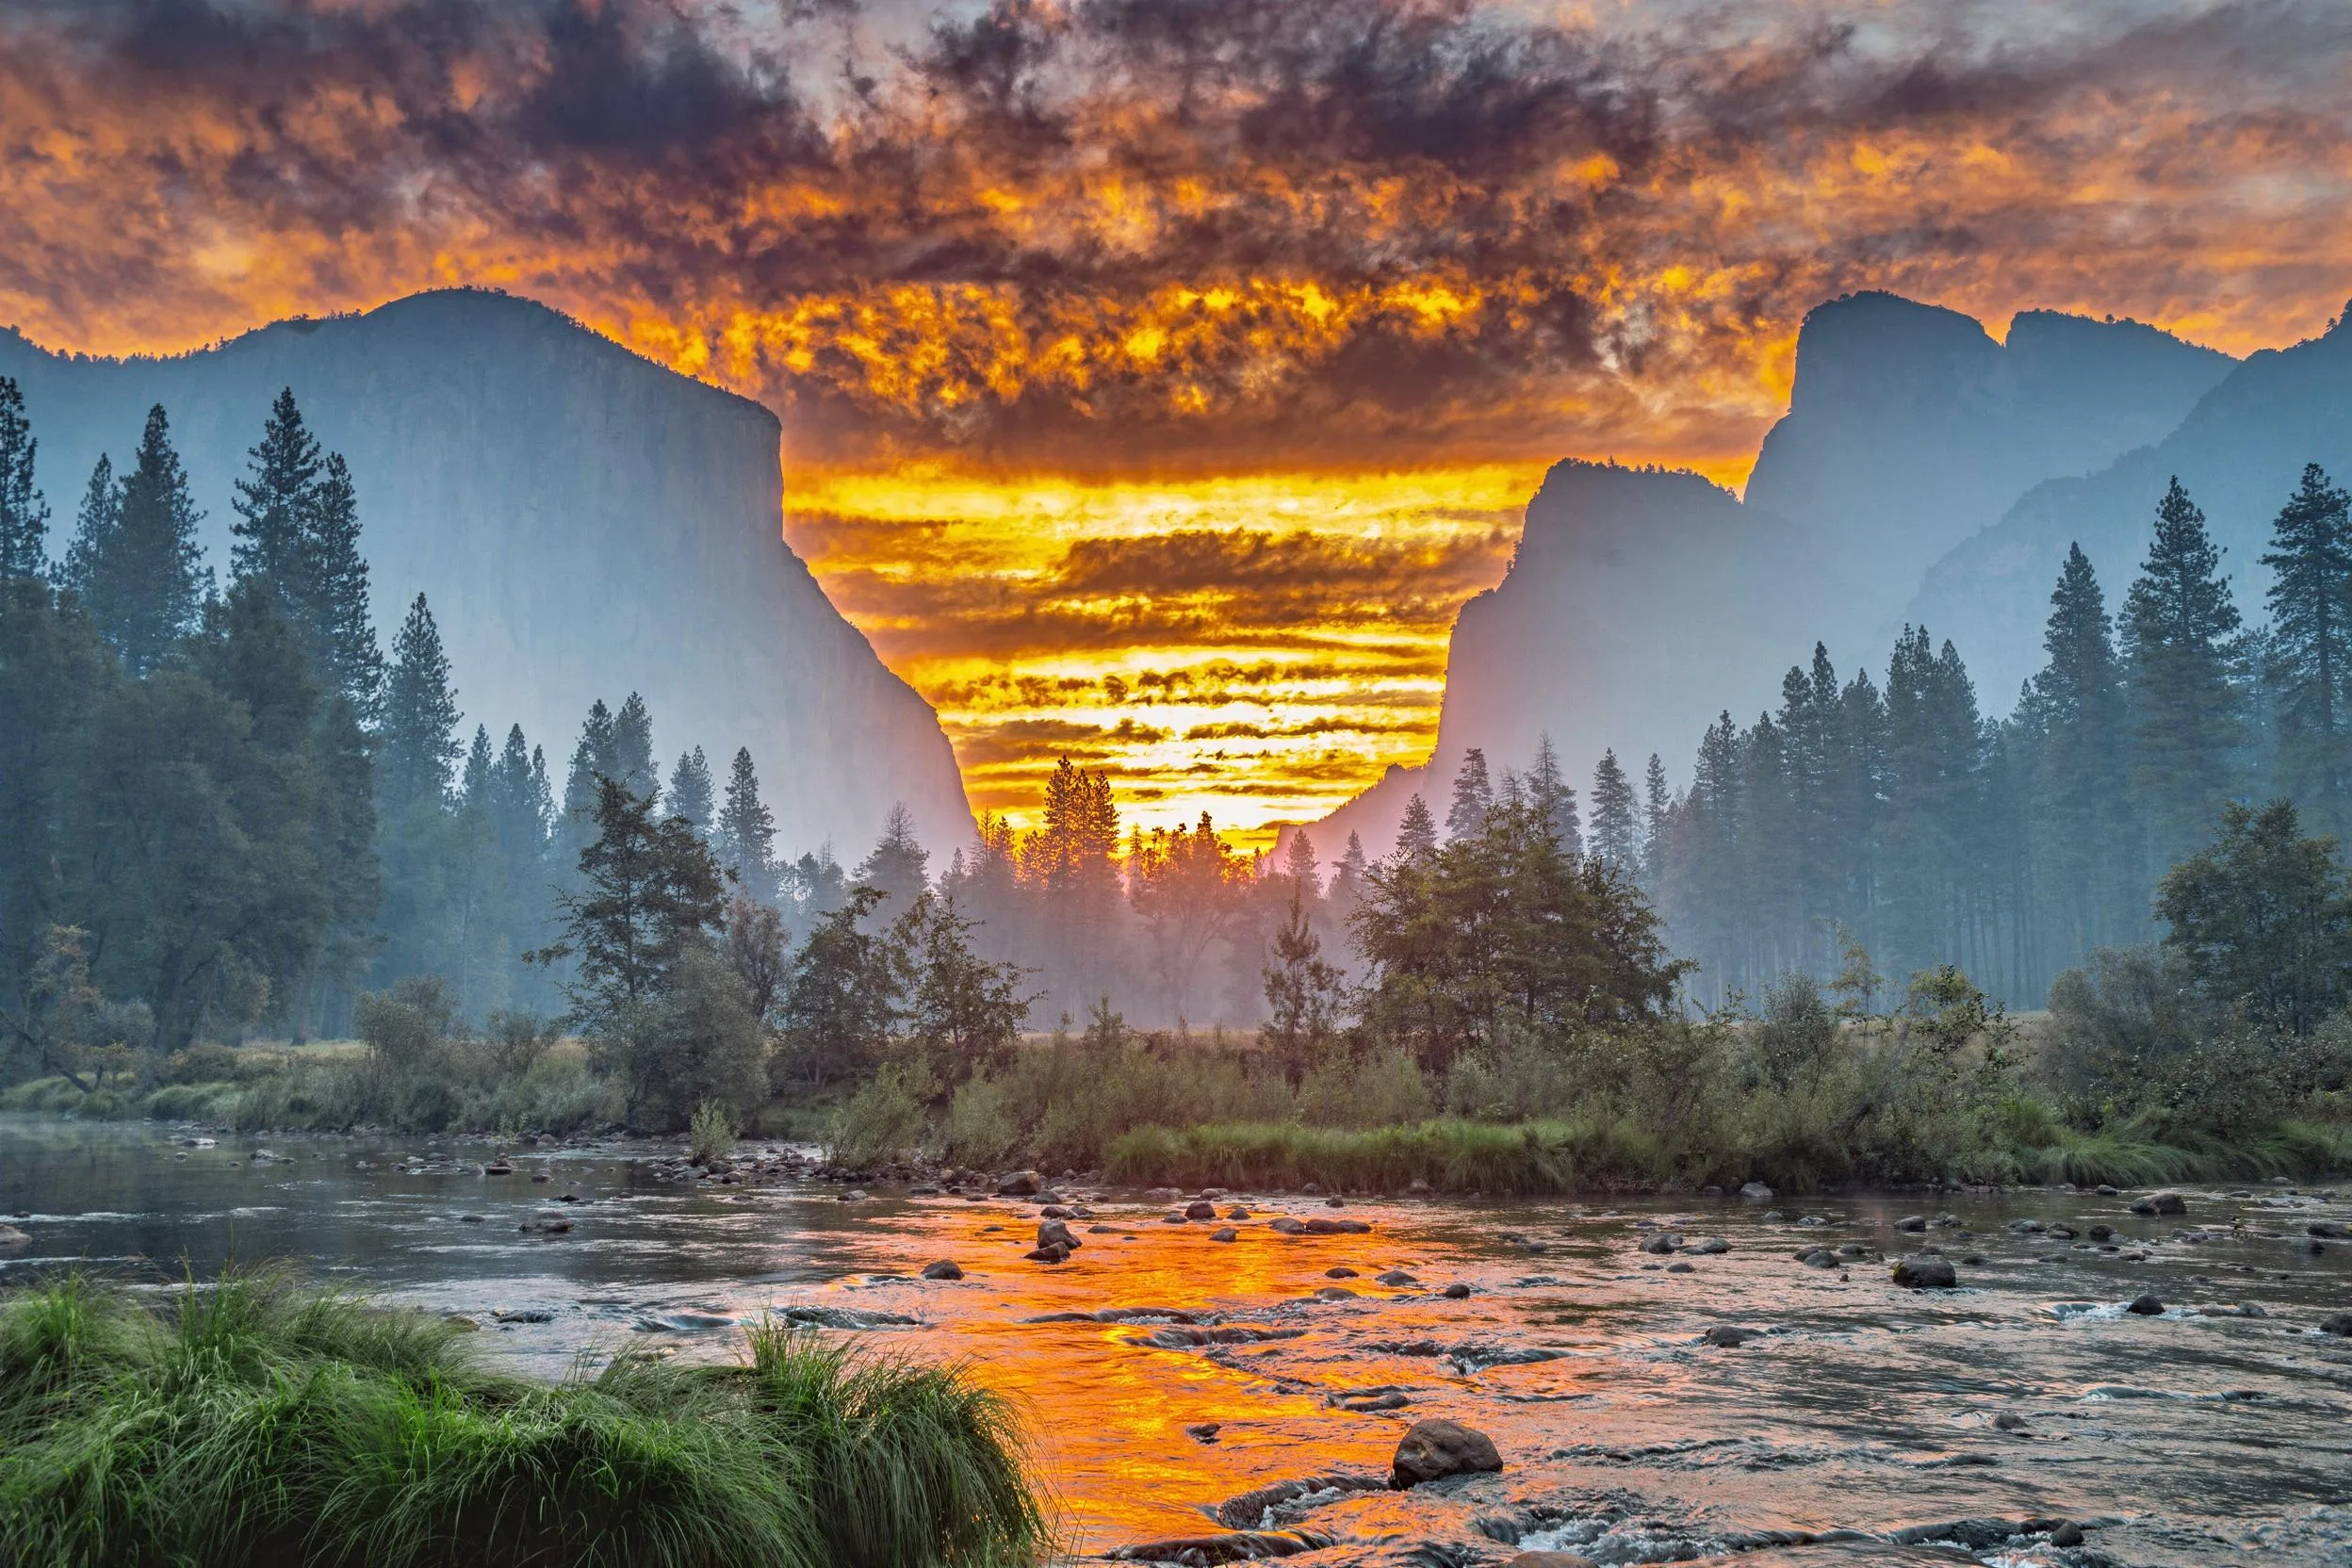

In [ ]:
# View original and edited images
edit_t.select(edit_t.original, edit_t.edited, edit_t.edit_prompt).show()

## Using Seeds for Reproducibility

Use the `seed` parameter to get reproducible results:


In [ ]:
# Create a table with seed support
seed_t = pxt.create_table(
    'bfl_demo.seeded',
    {'prompt': pxt.String, 'seed': pxt.Int},
    if_exists='replace'
)

seed_t.add_computed_column(
    image=bfl.generate(
        seed_t.prompt,
        model='flux-pro-1.1',
        width=512,
        height=512,
        seed=seed_t.seed
    )
)

# Same seed = same image
seed_t.insert([
    {'prompt': 'A red rose in a crystal vase', 'seed': 42},
    {'prompt': 'A red rose in a crystal vase', 'seed': 42},  # Same result
    {'prompt': 'A red rose in a crystal vase', 'seed': 123},  # Different result
])

Created table 'seeded'.
Added 0 column values with 0 errors.


Inserting rows into `seeded`: 3 rows [00:00, 1824.93 rows/s]
Inserted 3 rows with 0 errors.


3 rows inserted, 6 values computed.

prompt  seed  \
0  A red rose in a crystal vase    42   
1  A red rose in a crystal vase    42   
2  A red rose in a crystal vase   123   

                                               image  
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...
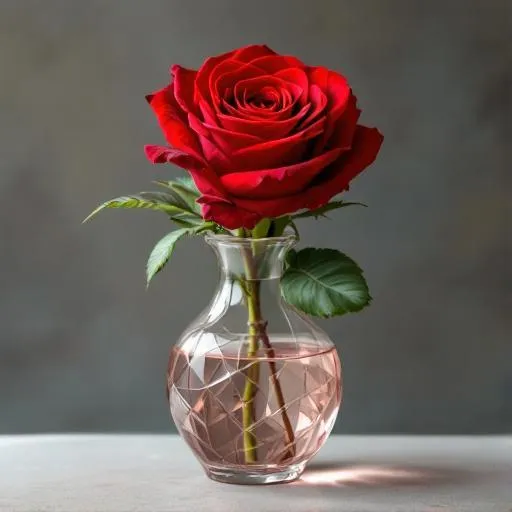
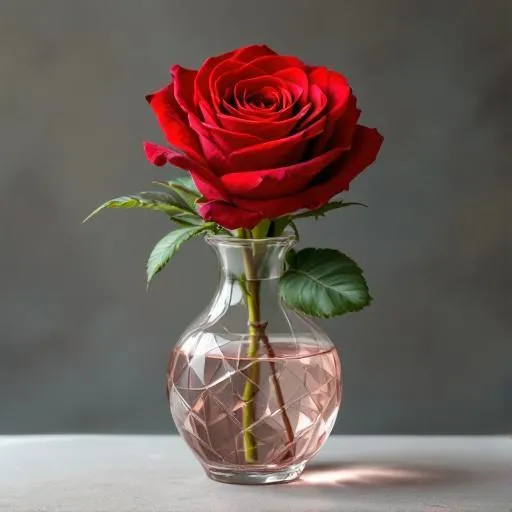
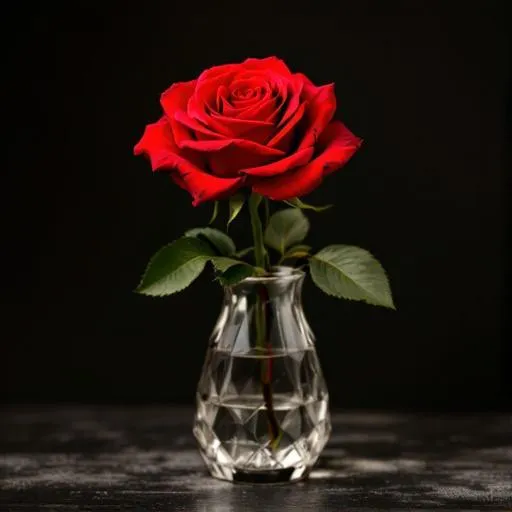

In [21]:
seed_t.collect()

## Image Expansion (Outpainting)

Expand an image beyond its original boundaries using `bfl.expand()`. This is perfect for:
- Making images wider or taller
- Adapting content for different aspect ratios
- Extending scenes naturally

In [ ]:
# Create a table for image expansion
expand_t = pxt.create_table(
    'bfl_demo.expanded',
    {'image': pxt.Image, 'expand_prompt': pxt.String},
    if_exists='replace'
)

# Add computed column to expand images horizontally
expand_t.add_computed_column(
    wide=bfl.expand(
        expand_t.expand_prompt,
        expand_t.image,
        left=256,   # Add 256 pixels to left
        right=256   # Add 256 pixels to right
    )
)

In [ ]:
# Insert an image to expand
expand_t.insert(
    image='https://images.unsplash.com/photo-1506744038136-46273834b3fb?w=1024',
    expand_prompt='Continue the mountain landscape with forests and valleys'
)

In [ ]:
# View original and expanded images
expand_t.select(expand_t.image, expand_t.wide).show()

## Inpainting with Fill

`bfl.fill()` allows you to inpaint specific regions of an image using a mask. This requires:
- An input image
- A mask image where **white areas** will be inpainted and **black areas** are preserved

```python
# Example usage (requires a mask image)
fill_t = pxt.create_table('bfl_demo.filled', {
    'image': pxt.Image,
    'mask': pxt.Image,
    'fill_prompt': pxt.String
})

fill_t.add_computed_column(
    filled=bfl.fill(
        fill_t.fill_prompt,
        fill_t.image,
        fill_t.mask,
        steps=50,      # Inference steps (max 50)
        guidance=30    # Guidance scale
    )
)
```

Use cases:
- Remove unwanted objects from photos
- Replace backgrounds
- Edit text in images
- Restore damaged areas

See [BFL Fill documentation](https://docs.bfl.ai/flux_tools/flux_1_fill) for more details.

## Best Practices

1. **Use specific prompts**: Include details about style, lighting, composition, and subject
2. **Start with flux-pro-1.1**: Fast and reliable for most use cases
3. **Use seeds for reproducibility**: When you need consistent results
4. **Resolution**: Minimum 64x64, max 4MP (2048x2048), dimensions must be multiples of 16
5. **Safety tolerance**: Default is 2; lower = stricter moderation (0-5 scale)

## Learn More

- [BFL Documentation](https://docs.bfl.ai/)
- [FLUX.2 Overview](https://docs.bfl.ai/flux_2/flux2_overview)
- [Text-to-Image API](https://docs.bfl.ai/flux_2/flux2_text_to_image)
- [Image Editing API](https://docs.bfl.ai/flux_2/flux2_image_editing)
- [Pricing](https://docs.bfl.ai/quick_start/pricing)
